In [1]:
!pip install pandas
!pip install scipy
!pip install scikit-learn
!pip install pytorch-tabnet
!pip install pyarrow fastparquet
!pip install colorama


In [4]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.callbacks import Callback

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

SEED = 42
n_splits = 5
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(2024)

def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*results)
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim*3),
            nn.ReLU(),
            nn.Linear(encoding_dim*3, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim*3),
            nn.ReLU(),
            nn.Linear(input_dim*3, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    data_tensor = torch.FloatTensor(df_scaled)
    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())
    
    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i : i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')
                 
    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()
        
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    return df_encoded

def feature_engineering(df):
    season_cols = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_cols, axis=1) 
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    df['BMI_PHR'] = df['Physical-BMI'] * df['Physical-HeartRate']
    df['SDS_InternetHours'] = df['SDS-SDS_Total_T'] * df['PreInt_EduHx-computerinternet_hoursday']
    return df

train = pd.read_csv('Dataset/train.csv')
test = pd.read_csv('Dataset/test.csv')
sample = pd.read_csv('Dataset/sample_submission.csv')

train_ts = load_time_series("Dataset/series_train.parquet")
test_ts = load_time_series("Dataset/series_test.parquet")

df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

# Perform autoencoder-based dimensionality reduction on time-series stats
train_ts_encoded = perform_autoencoder(df_train, encoding_dim=60, epochs=100, batch_size=32)
test_ts_encoded = perform_autoencoder(df_test, encoding_dim=60, epochs=100, batch_size=32)

time_series_cols = train_ts_encoded.columns.tolist()
train_ts_encoded["id"]=train_ts["id"]
test_ts_encoded['id']=test_ts["id"]

train = pd.merge(train, train_ts_encoded, how="left", on='id')
test = pd.merge(test, test_ts_encoded, how="left", on='id')

imputer = KNNImputer(n_neighbors=5)
numeric_cols = train.select_dtypes(include=[np.number]).columns
imputed_data = imputer.fit_transform(train[numeric_cols])
train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)
train_imputed['sii'] = train_imputed['sii'].round().astype(int)
for col in train.columns:
    if col not in numeric_cols:
        train_imputed[col] = train[col]
        
train = train_imputed
train = feature_engineering(train)
train = train.dropna(thresh=10, axis=0)
test = feature_engineering(test)
test.drop('id', axis=1, inplace=True)

featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total',
                'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday', 'sii', 
                'BMI_Age','Internet_Hours_Age','BMI_Internet_Hours', 'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 
                'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
                'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW', 'BMI_PHR', 'SDS_InternetHours']
featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset=['sii'])

featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total',
                'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'BMI_Age','Internet_Hours_Age','BMI_Internet_Hours',
                'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
                'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW', 'BMI_PHR', 'SDS_InternetHours']
featuresCols += time_series_cols

test = test[featuresCols]
if np.any(np.isinf(train)):
    train = train.replace([np.inf, -np.inf], np.nan)

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(
        oof_non_rounded < thresholds[0], 0,
        np.where(oof_non_rounded < thresholds[1], 1,
                 np.where(oof_non_rounded < thresholds[2], 2, 3))
    )

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

class TabNetPretrainedModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=1):
        super().__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.verbose = verbose
        self.best = float('inf') if mode == 'min' else -float('inf')
        
    def on_train_begin(self, logs=None):
        self.model = self.trainer
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            return
        if (self.mode == 'min' and current < self.best) or (self.mode == 'max' and current > self.best):
            if self.verbose:
                print(f'\nEpoch {epoch}: {self.monitor} improved from {self.best:.4f} to {current:.4f}')
            self.best = current
            if self.save_best_only:
                self.model.save_model(self.filepath)

class TabNetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.model = TabNetRegressor(**kwargs)
        self.kwargs = kwargs
        self.imputer = SimpleImputer(strategy='median')
        self.best_model_path = 'best_tabnet_model.pt'
        
    def fit(self, X, y):
        X_imputed = self.imputer.fit_transform(X)
        if hasattr(y, 'values'):
            y = y.values

        X_train, X_valid, y_train, y_valid = train_test_split(X_imputed, y, test_size=0.2, random_state=SEED)

        self.model.fit(
            X_train = X_train,
            y_train = y_train.reshape(-1, 1),
            eval_set = [(X_valid, y_valid.reshape(-1, 1))],
            eval_name = ['valid'],
            eval_metric = ['mse'],
            max_epochs = 200,
            patience = 20,
            batch_size = 1024,
            virtual_batch_size = 128,
            num_workers = 0,
            drop_last = False,
            callbacks = [
                TabNetPretrainedModelCheckpoint(
                    filepath = self.best_model_path,
                    monitor = 'valid_mse',
                    mode = 'min',
                    save_best_only = True,
                    verbose = True
                )
            ]
        )

        if os.path.exists(self.best_model_path):
            self.model.load_model(self.best_model_path)
            os.remove(self.best_model_path)

        return self

    def predict(self, X):
        X_imputed = self.imputer.transform(X)
        return self.model.predict(X_imputed).flatten()

def TrainTabNet(test_data):
    X = train.drop(['sii'], axis=1).values
    y = train['sii'].values

    imp = SimpleImputer(strategy='median')
    X = imp.fit_transform(X)
    test_data = imp.transform(test_data)

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    test_preds_all_folds = []

    for fold, (train_idx, val_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        tabnet_model = TabNetWrapper(n_d=64, n_a=64, n_steps=5, gamma=1.5,
                                     n_independent=2, n_shared=2, lambda_sparse=1e-4,
                                     optimizer_fn=torch.optim.Adam,
                                     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                                     mask_type='entmax',
                                     scheduler_params=dict(mode="min", patience=10, min_lr=1e-5, factor=0.5),
                                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                     verbose=1,
                                     device_name='cuda' if torch.cuda.is_available() else 'cpu')
        tabnet_model.fit(pd.DataFrame(X_train), y_train)

        y_val_pred = tabnet_model.predict(X_val)
        oof_non_rounded[val_idx] = y_val_pred

        train_preds = tabnet_model.predict(X_train)
        train_kappa = quadratic_weighted_kappa(y_train, np.round(train_preds).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, np.round(y_val_pred).astype(int))

        train_S.append(train_kappa)
        test_S.append(val_kappa)

        test_preds_fold = tabnet_model.predict(test_data)
        test_preds_all_folds.append(test_preds_fold)

        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    # Optimize thresholds
    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."

    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    test_preds = np.mean(np.column_stack(test_preds_all_folds), axis=1)
    tpTuned = threshold_Rounder(test_preds, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission

Submission_TabNet = TrainTabNet(test)
Submission_TabNet.to_csv('submission4.csv', index=False)
print("Submission created with TabNet only.")
Submission_TabNet


Training Folds: 100%|██████████| 5/5 [02:07<00:00, 25.42s/it]

Mean Train QWK --> 0.5491
Mean Validation QWK ---> 0.4469
----> || Optimized QWK SCORE ::  0.497
Submission created with TabNet only.


,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,1
3,00115b9f,0
4,0016bb22,1
5,001f3379,0
6,0038ba98,1
7,0068a485,1
8,0069fbed,1
9,0083e397,1


In [6]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.callbacks import Callback

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

SEED = 42
n_splits = 5
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(2024)

def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*results)
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim*3),
            nn.ReLU(),
            nn.Linear(encoding_dim*3, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim*3),
            nn.ReLU(),
            nn.Linear(input_dim*3, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    data_tensor = torch.FloatTensor(df_scaled)
    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())
    
    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i : i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')
                 
    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()
        
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    return df_encoded

def feature_engineering(df):
    season_cols = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_cols, axis=1) 
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    df['BMI_PHR'] = df['Physical-BMI'] * df['Physical-HeartRate']
    df['SDS_InternetHours'] = df['SDS-SDS_Total_T'] * df['PreInt_EduHx-computerinternet_hoursday']
    return df

train = pd.read_csv('Dataset/train.csv')
test = pd.read_csv('Dataset/test.csv')
sample = pd.read_csv('Dataset/sample_submission.csv')

train_ts = load_time_series("Dataset/series_train.parquet")
test_ts = load_time_series("Dataset/series_test.parquet")

df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

# Perform autoencoder-based dimensionality reduction on time-series stats
train_ts_encoded = perform_autoencoder(df_train, encoding_dim=60, epochs=100, batch_size=32)
test_ts_encoded = perform_autoencoder(df_test, encoding_dim=60, epochs=100, batch_size=32)

time_series_cols = train_ts_encoded.columns.tolist()
train_ts_encoded["id"]=train_ts["id"]
test_ts_encoded['id']=test_ts["id"]

train = pd.merge(train, train_ts_encoded, how="left", on='id')
test = pd.merge(test, test_ts_encoded, how="left", on='id')

imputer = KNNImputer(n_neighbors=5)
numeric_cols = train.select_dtypes(include=[np.number]).columns
imputed_data = imputer.fit_transform(train[numeric_cols])
train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)
train_imputed['sii'] = train_imputed['sii'].round().astype(int)
for col in train.columns:
    if col not in numeric_cols:
        train_imputed[col] = train[col]
        
train = train_imputed
train = feature_engineering(train)
train = train.dropna(thresh=10, axis=0)
test = feature_engineering(test)
test.drop('id', axis=1, inplace=True)

featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total',
                'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday', 'sii', 
                'BMI_Age','Internet_Hours_Age','BMI_Internet_Hours', 'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 
                'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
                'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW', 'BMI_PHR', 'SDS_InternetHours']
featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset=['sii'])

featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total',
                'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'BMI_Age','Internet_Hours_Age','BMI_Internet_Hours',
                'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
                'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW', 'BMI_PHR', 'SDS_InternetHours']
featuresCols += time_series_cols

test = test[featuresCols]
if np.any(np.isinf(train)):
    train = train.replace([np.inf, -np.inf], np.nan)

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(
        oof_non_rounded < thresholds[0], 0,
        np.where(oof_non_rounded < thresholds[1], 1,
                 np.where(oof_non_rounded < thresholds[2], 2, 3))
    )

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

class TabNetPretrainedModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=1):
        super().__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.verbose = verbose
        self.best = float('inf') if mode == 'min' else -float('inf')
        
    def on_train_begin(self, logs=None):
        self.model = self.trainer
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            return
        if (self.mode == 'min' and current < self.best) or (self.mode == 'max' and current > self.best):
            if self.verbose:
                print(f'\nEpoch {epoch}: {self.monitor} improved from {self.best:.4f} to {current:.4f}')
            self.best = current
            if self.save_best_only:
                self.model.save_model(self.filepath)

class TabNetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.model = TabNetRegressor(**kwargs)
        self.kwargs = kwargs
        self.imputer = SimpleImputer(strategy='median')
        self.best_model_path = 'best_tabnet_model.pt'
        self.train_losses = []
        self.val_losses = []

    def fit(self, X, y):
        X_imputed = self.imputer.fit_transform(X)
        if hasattr(y, 'values'):
            y = y.values

        X_train, X_valid, y_train, y_valid = train_test_split(X_imputed, y, test_size=0.2, random_state=SEED)

        self.model.fit(
            X_train=X_train,
            y_train=y_train.reshape(-1, 1),
            eval_set=[(X_valid, y_valid.reshape(-1, 1))],
            eval_name=['valid'],
            eval_metric=['mse'],
            max_epochs=200,
            patience=20,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False,
            callbacks=[
                TabNetPretrainedModelCheckpoint(
                    filepath=self.best_model_path,
                    monitor='valid_mse',
                    mode='min',
                    save_best_only=True,
                    verbose=True
                )
            ]
        )

        # Extract loss history from the TabNet model
        self.train_losses = self.model.history['loss']
        self.val_losses = self.model.history['valid_mse']

        if os.path.exists(self.best_model_path):
            self.model.load_model(self.best_model_path)
            os.remove(self.best_model_path)

        return self

    def predict(self, X):
        """
        Predicts the output for the given input data.
        
        Args:
            X (numpy.ndarray): The input data.
        
        Returns:
            numpy.ndarray: Predicted values.
        """
        X_imputed = self.imputer.transform(X)
        predictions = self.model.predict(X_imputed)
        return predictions.flatten()



def TrainTabNet(test_data):
    X = train.drop(['sii'], axis=1).values
    y = train['sii'].values

    imp = SimpleImputer(strategy='median')
    X = imp.fit_transform(X)
    test_data = imp.transform(test_data)

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    test_preds_all_folds = []

    for fold, (train_idx, val_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        tabnet_model = TabNetWrapper(n_d=64, n_a=64, n_steps=5, gamma=1.5,
                                     n_independent=2, n_shared=2, lambda_sparse=1e-4,
                                     optimizer_fn=torch.optim.Adam,
                                     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                                     mask_type='entmax',
                                     scheduler_params=dict(mode="min", patience=10, min_lr=1e-5, factor=0.5),
                                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                     verbose=1,
                                     device_name='cuda' if torch.cuda.is_available() else 'cpu')
        tabnet_model.fit(pd.DataFrame(X_train), y_train)

        y_val_pred = tabnet_model.predict(X_val)
        oof_non_rounded[val_idx] = y_val_pred

        train_preds = tabnet_model.predict(X_train)
        train_kappa = quadratic_weighted_kappa(y_train, np.round(train_preds).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, np.round(y_val_pred).astype(int))

        train_S.append(train_kappa)
        test_S.append(val_kappa)

        test_preds_fold = tabnet_model.predict(test_data)
        test_preds_all_folds.append(test_preds_fold)

        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    # Optimize thresholds
    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."

    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    test_preds = np.mean(np.column_stack(test_preds_all_folds), axis=1)
    tpTuned = threshold_Rounder(test_preds, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission

Submission_TabNet = TrainTabNet(test)
Submission_TabNet.to_csv('submission4.csv', index=False)
print("Submission created with TabNet only.")
Submission_TabNet


Training Folds: 100%|██████████| 5/5 [02:09<00:00, 25.84s/it]

Mean Train QWK --> 0.5491
Mean Validation QWK ---> 0.4469
----> || Optimized QWK SCORE ::  0.497
Submission created with TabNet only.


,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,1
3,00115b9f,0
4,0016bb22,1
5,001f3379,0
6,0038ba98,1
7,0068a485,1
8,0069fbed,1
9,0083e397,1


epoch 0  | loss: 7.13858 | valid_mse: 1858.75647|  0:00:00s

Epoch 0: valid_mse improved from inf to 1858.7565
Successfully saved model at best_tabnet_model.pt.zip
epoch 1  | loss: 3.30068 | valid_mse: 619.22884|  0:00:00s

Epoch 1: valid_mse improved from 1858.7565 to 619.2288
Successfully saved model at best_tabnet_model.pt.zip
epoch 2  | loss: 2.55505 | valid_mse: 274.05825|  0:00:01s

Epoch 2: valid_mse improved from 619.2288 to 274.0583
Successfully saved model at best_tabnet_model.pt.zip
epoch 3  | loss: 2.3046  | valid_mse: 143.3363|  0:00:01s

Epoch 3: valid_mse improved from 274.0583 to 143.3363
Successfully saved model at best_tabnet_model.pt.zip
epoch 4  | loss: 1.63306 | valid_mse: 30.74809|  0:00:02s

Epoch 4: valid_mse improved from 143.3363 to 30.7481
Successfully saved model at best_tabnet_model.pt.zip
epoch 5  | loss: 1.24744 | valid_mse: 33.71001|  0:00:02s
epoch 6  | loss: 1.25784 | valid_mse: 16.01692|  0:00:02s

Epoch 6: valid_mse improved from 30.7481 to 16.0169
S

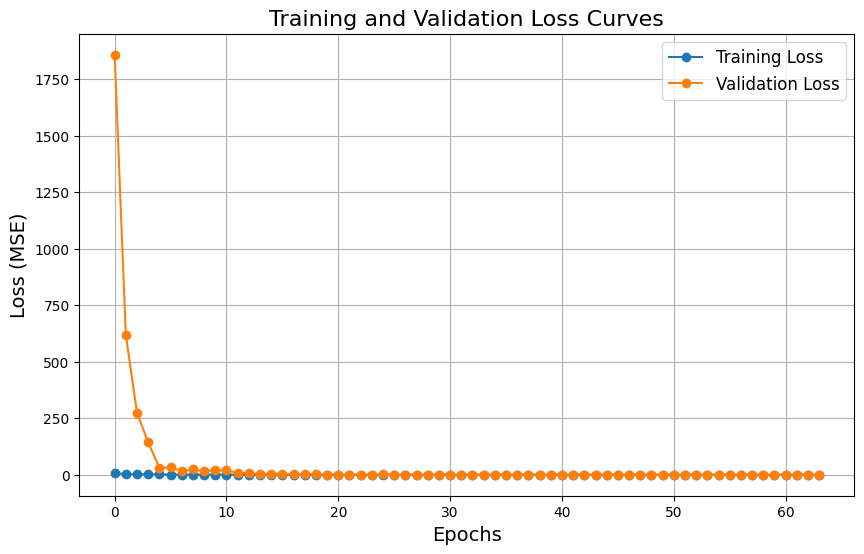

In [7]:
import matplotlib.pyplot as plt

def plot_loss_curves(tabnet_wrapper):
    """
    Plots the training and validation loss curves for TabNet.

    :param tabnet_wrapper: The TabNetWrapper instance after training.
    """
    train_losses = tabnet_wrapper.train_losses
    val_losses = tabnet_wrapper.val_losses

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss", marker='o')
    plt.plot(val_losses, label="Validation Loss", marker='o')
    plt.title("Training and Validation Loss Curves", fontsize=16)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Loss (MSE)", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

# Example usage after training:
tabnet_model = TabNetWrapper(n_d=64, n_a=64, n_steps=5, gamma=1.5,
                             n_independent=2, n_shared=2, lambda_sparse=1e-4,
                             optimizer_fn=torch.optim.Adam,
                             optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                             mask_type='entmax',
                             scheduler_params=dict(mode="min", patience=10, min_lr=1e-5, factor=0.5),
                             scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                             verbose=1,
                             device_name='cuda' if torch.cuda.is_available() else 'cpu')

# Train the model (example training procedure)
X_train, X_val, y_train, y_val = train_test_split(train.drop(['sii'], axis=1), train['sii'], test_size=0.2, random_state=SEED)
tabnet_model.fit(X_train, y_train)

# Plot loss curves
plot_loss_curves(tabnet_model)


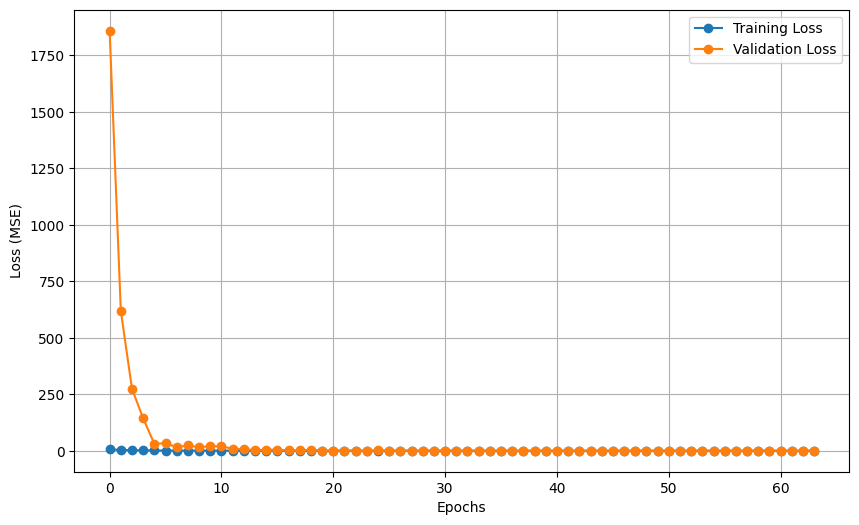

In [9]:
import matplotlib.pyplot as plt

def plot_loss_curves(tabnet_wrapper):
    """
    Plots the training and validation loss curves for TabNet.

    :param tabnet_wrapper: The TabNetWrapper instance after training.
    """
    train_losses = tabnet_wrapper.train_losses
    val_losses = tabnet_wrapper.val_losses

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss", marker='o')
    plt.plot(val_losses, label="Validation Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage:
plot_loss_curves(tabnet_model)


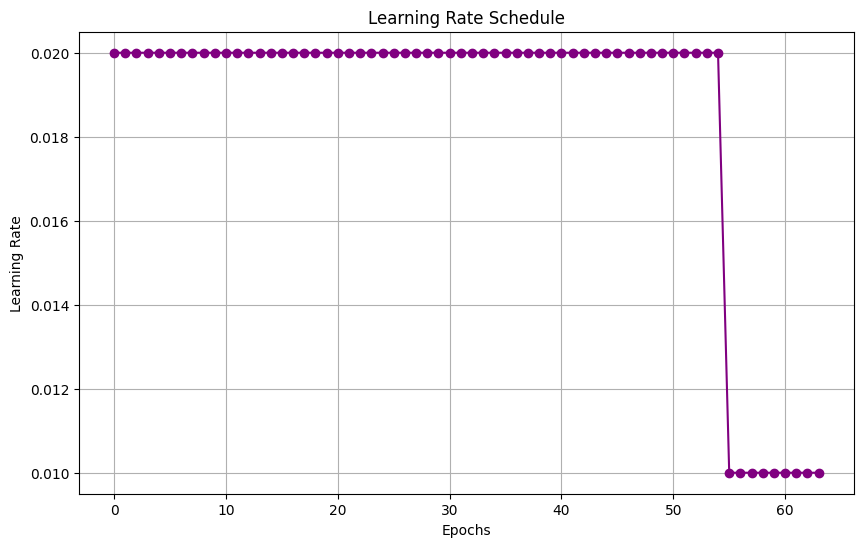

In [10]:
learning_rates = tabnet_model.model.history['lr']
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, marker='o', color='purple')
plt.title("Learning Rate Schedule")
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.grid()
plt.show()
